**Assignment2 -Parte 1 ResNet18**

Trabalho realizado por:

Telmo Cunha 2018308321


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/YOLO

/content/gdrive/MyDrive/YOLO


In [ ]:
%ls

checkpoints/  datasets.py   KITTI_dataset/  Results/          train.py
config/       datasplit.py  models.py       Results_weights/  utils.py
data/         detect.py     __pycache__/    test.py           weights/


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
from google.colab.patches import cv2_imshow # for image display
from skimage import io
import matplotlib.pyplot as plt
import math
from PIL import Image
import pickle

from torch.utils import data
from torchvision import transforms
#import torchvision.transforms as transforms
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models




Dataset

In [ ]:
#maybe done


#load of the images and the labels

path_images=sorted(glob.glob("KITTI_dataset/Imgs/*.png"))
path_labels=sorted(glob.glob("KITTI_dataset/labels/*.txt"))

#images=np.empty((375,1242))
images=[]
labels=[]
dataset=[]

for i in path_images:
  img=cv.imread(i)
  images.append(img)

print("Size of images:",str(len(images)))



Size of images: 500


In [ ]:
labeltxt=np.loadtxt(path_labels[0])

In [ ]:

dataset_images=[]
dataset_labels=[]
aux=0
for j in range(500):
  image=np.array(images[j])
  himage,wimage,channels=image.shape
  labeltxt=np.loadtxt(path_labels[j])
  dados= labeltxt.ravel()
  # print("dados:", dados)
  aux+=len(dados)/5
  for i in range(0,len(dados),5): 
    
    label=dados[i]

    xcentric= dados[i+1]
    ycentric= dados[i+2]

    width= dados[i+3]
    heigth= dados[i+4]

    # print("label",label,"\nxcentric:", xcentric,"ycentric:",ycentric,"width:", width,"heigth:",heigth)

    #math.floor
    x1n=float(xcentric) - (float(width)/2)
    y1n=float(ycentric) - (float(heigth)/2)

    x2n=float(xcentric) + (float(width)/2)
    y2n=float(ycentric) + (float(heigth)/2)

    x1=math.floor(x1n*wimage)
    y1=math.floor(y1n*himage)
    x2=math.floor(x2n*wimage)
    y2=math.floor(y2n*himage)

    # print("x1", x1,"y1",y1,"x2:", x2,"y2",y2)

    cropimage=image[y1:y2,x1:x2,:]
    # print("\n Debug-> bounding box:")
    # print("cropimage:\n", cropimage)
    
    cropimage=cv.resize(cropimage, dsize=(64, 64), interpolation=cv.INTER_CUBIC)
    
    # print("\n Debug crop image size:")
    # print(cropimage.shape)

    dataset_images.append(cropimage)
    dataset_labels.append(label)
    # print("\n Debug-> verificar se tem a label e imagem:")
    # print("Debug len dataset images:", len(dataset_images))
    # print("\n degub label:",dataset_labels)

    



print("Size of dataset:",str(len(dataset_images)))
print("Size of dataset:",str(len(dataset_labels)))

with open('dataset.pickle', 'wb') as f:
    pickle.dump([dataset_labels,dataset_images], f)




Size of dataset: 2500
Size of dataset: 2500


In [ ]:

class Dataset (data.Dataset):
  def __init__ (self , images , labels):
    self.images = images
    self.labels = labels
  def __len__ ( self ):
    return len( self.images )
  def __getitem__ (self , index ):
    img = np.array(self.images[index])
    img= transforms.ToTensor()(img)
    label = self.labels [ index ]
    return img , label

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = models.resnet18(pretrained=True)

# for param in cnn_model.parameters ():
#   param.requires_grad = False

cnn_model.fc=nn.Linear(512,3)

cnn_model=cnn_model.to(device)


# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 32, 32), batch_size = 5) 



The model will run on cpu


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 64, 16, 16]           9,408
       BatchNorm2d-2            [5, 64, 16, 16]             128
              ReLU-3            [5, 64, 16, 16]               0
         MaxPool2d-4              [5, 64, 8, 8]               0
            Conv2d-5              [5, 64, 8, 8]          36,864
       BatchNorm2d-6              [5, 64, 8, 8]             128
              ReLU-7              [5, 64, 8, 8]               0
            Conv2d-8              [5, 64, 8, 8]          36,864
       BatchNorm2d-9              [5, 64, 8, 8]             128
             ReLU-10              [5, 64, 8, 8]               0
       BasicBlock-11              [5, 64, 8, 8]               0
           Conv2d-12              [5, 64, 8, 8]          36,864
      BatchNorm2d-13              [5, 64, 8, 8]             128
             ReLU-14              [5

In [ ]:
with open('dataset.pickle','rb') as f:
    data_lab,data_img = pickle.load(f)

dataset=Dataset(images= data_img,labels= data_lab)

# transform_train2= tt.Compose([tt.ToTensor(),
#                               tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform_train = tt.Compose([tt.ToTensor(),
#                               tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalize all the images
#                               tt.RandomInvert(0.5),       
#                               tt.RandomHorizontalFlip(0.5),       #Flips the image horizontal axis
#                               tt.RandomRotation((-45,45))#Rotates the image to a specified angel 
                                                         
#                               ])

# #tt.ColorJitter(0.2,0.2,0.3,0.3), #brightness, contrast , saturation, hue  
# transform = tt.Compose([tt.Resize((32,32)),
#                          tt.ToTensor(),
#                          tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                        ])

#transform = tt. ToTensor ()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
training_data, testing_data = torch.utils.data.random_split(dataset, [train_size, test_size])

# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(testing_data))) # 10 000

Number of images in original training set: 2000
Split Number: 400
Number of training images: 1600
Number of validation images: 400
Number of images in the testing set: 500


In [ ]:

from torch.utils.data.sampler import SubsetRandomSampler # Sampler
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


batch_size = 28 # 100 images per batch and per epoch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)
classes = ['car','person','cyclist']

In [ ]:
# Library imports
import torch.optim as optim
import tensorflow as tf

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters

num_epochs = 20
loss_values = []
lr=0.0001  

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems


# Optimizer Algorithm
#optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
optimizer = optim.RAdam(cnn_model.parameters(), lr = lr)
#optimizer =optim.RMSprop(cnn_model.parameters(),lr=lr)

# Training
running_loss = 0.0
training_loss =0.0

y_valid= list()
y_train= list()
#adaptive learning rate
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.1,patience=4)

for epoch in range(num_epochs):
  
  for batch_id, data in enumerate(training_loader, 0):
    
    #Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    

    images=images.type(torch.FloatTensor)
    labels=labels.type(torch.LongTensor)

    images, labels = images.to(device), labels.to(device)



    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    training_loss+= loss.item()
    running_loss += loss.item()
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0
    
  y_train.append(training_loss/(len(training_idx)/batch_size))
  training_loss=0.0
  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)

      valid_outputs=valid_outputs.type(torch.FloatTensor)
      valid_labels=valid_labels.type(torch.LongTensor)

      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
  
  validation_loss= valid_total_loss/len(valid_idx)
  loss_values.append(validation_loss)
  y_valid.append(valid_total_loss/(len(valid_idx)/batch_size))
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))
  print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
  #scheduler.step(loss)


print("Training is completed!")

(Validation Set) Epoch: 1 Loss: 0.02865474909543991 Acc: 68.25
Epoch-0 lr: 0.0001
(Validation Set) Epoch: 2 Loss: 0.016069535315036774 Acc: 88.0
Epoch-1 lr: 0.0001
(Validation Set) Epoch: 3 Loss: 0.010523084085434675 Acc: 90.25
Epoch-2 lr: 0.0001
(Validation Set) Epoch: 4 Loss: 0.008324462696909904 Acc: 92.25
Epoch-3 lr: 0.0001
(Validation Set) Epoch: 5 Loss: 0.007063896395266056 Acc: 93.25
Epoch-4 lr: 0.0001
(Validation Set) Epoch: 6 Loss: 0.006567744193598628 Acc: 93.5
Epoch-5 lr: 0.0001
(Validation Set) Epoch: 7 Loss: 0.0060682503692805765 Acc: 93.25
Epoch-6 lr: 0.0001
(Validation Set) Epoch: 8 Loss: 0.008227919545024633 Acc: 92.75
Epoch-7 lr: 0.0001
(Validation Set) Epoch: 9 Loss: 0.006703427580650896 Acc: 94.5
Epoch-8 lr: 0.0001
(Validation Set) Epoch: 10 Loss: 0.006764299876522273 Acc: 92.75
Epoch-9 lr: 0.0001
(Validation Set) Epoch: 11 Loss: 0.00798399256542325 Acc: 93.75
Epoch-10 lr: 0.0001
(Validation Set) Epoch: 12 Loss: 0.0070619579683989285 Acc: 93.5
Epoch-11 lr: 0.0001
(Va

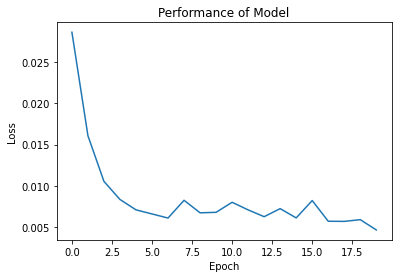

In [ ]:
plt.plot(loss_values)
plt.xlabel ("Epoch")
plt.ylabel ("Loss")
plt.title ("Performance of Model")
plt.show()

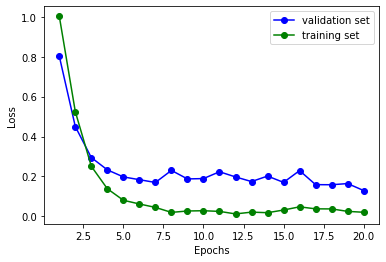

In [ ]:
# plot  
x = list(range(1, num_epochs+1))
plt.plot(x, y_valid, 'bo-', label ='validation set')
plt.plot(x, y_train, 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

Accuracy using 500 test images: 94.6 %

Accuracy of  0 : 99 % in 418 Images
Accuracy of  1 : 81 % in 53 Images
Accuracy of  2 : 44 % in 29 Images

 Mean class accuracy:75.2401424096113%

Confusion Matrix
[[417   8   5]
 [  1  43  11]
 [  0   2  13]]




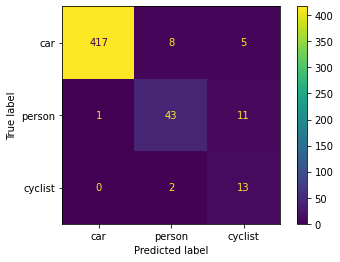


Global F1 score:100.0
Mean F1 score:100.0
Mean precision:100.0
Mean recall 100.0


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 3
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images=images.type(torch.FloatTensor)
    labels=labels.type(torch.LongTensor)
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):  
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix += confusion_matrix(predicted.cpu(),labels.cpu(),labels=[x for x in range(num_classes)])

mean_accuracy=list()
# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
    mean_accuracy.append(100*class_correct[i]/ class_total[i])


mean_accuracy= sum(mean_accuracy)/ num_classes
print("\n Mean class accuracy:"+str(mean_accuracy)+"%")


# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix) 

print('\n')
conf_disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                       display_labels = classes)
conf_disp.plot()
plt.show()

f1micro = f1_score(labels.cpu(),predicted.cpu(),average="micro")
f1mean = f1_score(labels.cpu(),predicted.cpu(),average="weighted")
precision=precision_score(labels.cpu(),predicted.cpu(),average="weighted")
recall=recall_score(labels.cpu(),predicted.cpu(),average="weighted")


print("\nGlobal F1 score:"+str(f1micro*100))
print("Mean F1 score:"+str(f1mean*100))
print("Mean precision:"+str(precision*100))
print("Mean recall", str(recall*100))
